In [4]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(anndata))
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(InteractionSet))
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [5]:
minmax <- function(x){
    res <- (x-min(x)) / (max(x) - min(x)) 
    return(res)
}

scale01_mat <- function(m) {
  mins  <- apply(m, 2, min, na.rm = TRUE)
  maxs  <- apply(m, 2, max, na.rm = TRUE)
  denom <- pmax(maxs - mins, 1e-12)
  sweep(sweep(m, 2, mins, "-"), 2, denom, "/")
}

group_means <- function(m, g) {
  rs   <- rowsum(m, g, reorder = FALSE)
  cnts <- as.numeric(table(g)[rownames(rs)])
  sweep(rs, 1, cnts, "/")
}

In [6]:
library(reticulate)
use_condaenv("/projects/ps-renlab2/y2xie/miniconda3/envs/seurat", required = TRUE)

In [7]:
### For networks
library(igraph)
# browserClientJs <- getBrowserClientJs()
# IRdisplay::display_javascript(browserClientJs)


Attaching package: ‘igraph’


The following object is masked from ‘package:GenomicRanges’:

    union


The following object is masked from ‘package:IRanges’:

    union


The following object is masked from ‘package:S4Vectors’:

    union


The following objects are masked from ‘package:BiocGenerics’:

    normalize, path, union


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [8]:
### Add brain region color
cols <- read.csv("../../ref/yel_Science2023_supp/brain_dissection_anno.xls", sep = "\t")
col1 <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.color) %>% unlist
names(col1) <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.name) %>% unlist

col2 <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region.color) %>% unlist
names(col2) <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region) %>% unlist

In [9]:
cols <- read.csv("../../ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("../04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

bcol <- read.csv("../Figure/superterm.color", row.names = 1, sep = "\t")
ccol3 <- bcol$bcol
names(ccol3) <- rownames(bcol)

In [10]:
corder <- read.table("../04.clustering/order.subclass.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character
corder2 <- read.table("../04.clustering/order.cluster.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character

In [11]:
library(scales)
library(TSP)
hex_colors <- c("#634aad","#b5b235","#577ceb","#60b04c","#9778e2","#9fc05c","#462b7a","#64c77a","#cf5eb6","#4ac08f","#d84889",
                "#33d4d1","#da504c","#5885de","#d38a32","#5759a2","#b69c41","#b274d4","#5d7b25","#89317c","#3c7a3b","#cc8ad2","#bea65e",
                "#6f97dd","#be542b","#782252","#da8b57","#a83769","#875a1d","#dd79a5","#7f2618","#d0496b","#d2745b","#89253d","#df646b","#a4303d","#ce6c7a")

rgb <- col2rgb(hex_colors)
tsp <- as.TSP(dist(t(rgb)))
sol <- solve_TSP(tsp, control = list(repetitions = 1e3))
sorted_colors <- hex_colors[sol]

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


In [12]:
pair_df <- read.table("/projects//ps-renlab2/y2xie/projects/BICAN/analysis/06.integration/snm3c_snATAC_DPT_RNA_250601.pred_subclass_match.txt", header = T) %>%
mutate(snm3c = ifelse(snm3c == "Lamp5_Lhx6", "Lamp5_LHX6", snm3c))

dim(pair_df)

[1] 32  3

In [13]:
rmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", sep = '\t')
rumap <- read.csv("../04.clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_umap.txt", sep = "\t", header = T)

In [14]:
gaba <- rmeta %>% filter(class == "GABA") %>% select(subclass_corrected) %>% unlist %>% unique %>% as.character
glut <- rmeta %>% filter(class == "Glut") %>% select(subclass_corrected) %>% unlist %>% unique %>% as.character
nonn <- rmeta %>% filter(class == "NonN") %>% select(subclass_corrected) %>% unlist %>% unique %>% as.character

In [15]:
hg38 <- read.table("/projects//ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")
head(hg38, 2)

V1   V2    V3    V4 V5              V6         
1 chr1 11868 14409 +  ENSG00000290825 DDX11L2    
2 chr1 29553 31109 +  ENSG00000243485 MIR1302-2HG

In [16]:
# badcelltype <- c("ENDO", "IMMUNE", "L5ET", "SST-CHODL")
badcelltype <- c('IMMUNE' ,'ENDO', 'FBL', 'SST-CHODL', 'L5ET', 'MSN') ### from chromatin states!

In [17]:
### show grn in the same order of abc
ncorder <- read.table("../08.conns/plot/H3K27ac_abc_filtcelltype_wubin_pair_select_nmf_H3K27ac.xls", sep = "\t", row.names = 1, header = T)
colnames(ncorder) <- gsub("\\.", "-", colnames(ncorder))

In [15]:
abcif <- read.table("../08.conns/plot/broad_abc_filtcelltype_conns.txt", header = T)

## Plot H3K27ac SCENIC+ results

In [27]:
egrn <- read.table("scplus_pipeline/Snakemake/eRegulon_direct.tsv", sep = '\t', header = T)
head(egrn, 2)
table(abs(egrn$rho_R2G) > 0.05)

Region                  Gene    importance_R2G rho_R2G importance_x_rho
1 chr17:50564821-50565320 CACNA1G 0.626754       1       0.626754        
2 chr2:60569595-60570094  BCL11A  0.220971       1       0.220971        
  importance_x_abs_rho TF  is_extended eRegulon_name  Gene_signature_name 
1 0.626754             AHR False       AHR_direct_+/+ AHR_direct_+/+_(23g)
2 0.220971             AHR False       AHR_direct_+/+ AHR_direct_+/+_(23g)
  Region_signature_name importance_TF2G regulation rho_TF2G   triplet_rank
1 AHR_direct_+/+_(24r)  1.033537        1          0.07140344 2618        
2 AHR_direct_+/+_(24r)  1.631735        1          0.17073798 6429


 TRUE 
19929 

In [51]:
hg38tss <- hg38 %>%
mutate(tss = ifelse(V4 == "+", V2, V3-1)) %>%
mutate(tss2 = tss+1) %>%
dplyr::select(V1, tss, tss2, V4, V5, V6) %>%
setNames(c("chrom2", "start2", "end2", "strand", "ensembl", "gene"))

tdf <- egrn %>% dplyr::select(Region, Gene)
tdf[,c("chrom1", "start1", "end1")] <- stringr::str_split_fixed(tdf$Region, pattern = "[:-]", n = 3)
tdf <- merge(tdf, hg38tss, by.x = 'Gene', by.y = 'gene')

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


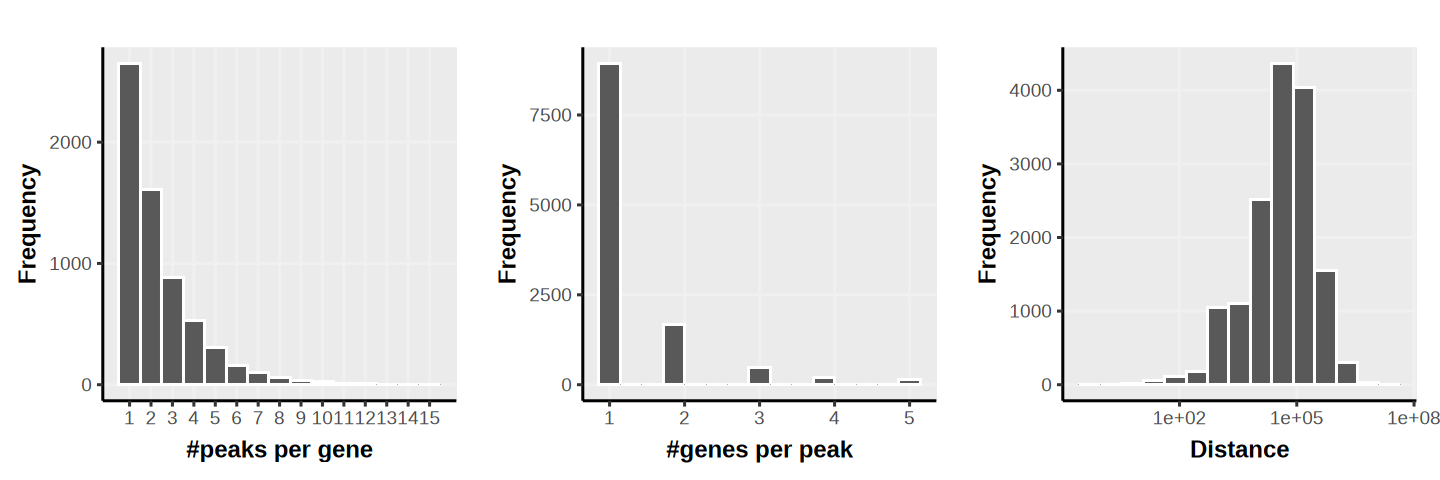

In [52]:
t1 <- tdf %>% 
dplyr::select(Region, Gene) %>% distinct %>%
group_by(Gene) %>%
summarise(ngene = n_distinct(Region)) %>%
ungroup %>% 
mutate(ngene = ifelse(ngene > 15, 15, ngene)) %>%
ggplot(aes(x = ngene)) +
geom_histogram(color = "white", bins = 15) + 
scale_x_continuous(breaks = seq(1, 15, 1)) + 
theme_Publication() + 
xlab("#peaks per gene") + ylab("Frequency")

t2 <- tdf %>%
dplyr::select(Region, Gene) %>% distinct %>%
group_by(Region) %>%
summarise(ngene = n_distinct(Gene)) %>%
ungroup %>% 
mutate(ngene = ifelse(ngene > 5, 5, ngene)) %>%
ggplot(aes(x = ngene)) +
geom_histogram(color = "white", bins = 15) + 
scale_x_continuous(breaks = seq(1, 5, 1)) + 
theme_Publication() + 
xlab("#genes per peak") + ylab("Frequency")

t3 <- tdf %>%
mutate(dist = abs(start2 - (as.integer(start1) + as.integer(end1))/2)) %>%
dplyr::select(Region, Gene, dist) %>% distinct %>%
ggplot(aes(x = dist)) + 
geom_histogram(color = "white", bins = 15) + 
theme_Publication() + scale_x_log10() +
xlab("Distance") + ylab("Frequency")

fig1 <- cowplot::plot_grid(t1, t2, t3, ncol = 3)
options(repr.plot.width = 12, repr.plot.height = 4)
fig1

In [17]:
### validate: is the abc being filtered significant?
bs2025 <- read.csv("../../ref/Ben-Simon2025Cell_enhancer_list.xls", sep = "\t", header = T)
bs2025e <- bs2025 %>%
filter(X %in% c("On_Target_strong", "On_Target_weak", "On_Targt_weak", "Mixed_Target_strong", "Mixed_Target_weak")) %>%
filter(Species == "hg38", Type %in% c("Enhancer", "Bashed enhancer")) %>%
dplyr::select(Coordinates, Primary.TCP, Secondary.TCP.s, X) %>%
mutate(X = ifelse(X == "", "unknown", X))
bs2025e[,c("chrom", "start", "end")] <- stringr::str_split_fixed(bs2025e$Coordinates, pattern = "[:-]", n = 3)

In [53]:
nrow(bs2025e)
lrange1 <- GRanges(bs2025e[,"chrom"], ranges = IRanges(as.integer(bs2025e[,"start"]), as.integer(bs2025e[,"end"])))
lrange2 <- GRanges(tdf[,"chrom1"], ranges = IRanges(as.integer(tdf[,"start1"]), as.integer(tdf[,"end1"])))
queryHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length

[1] 118

[1] 7

In [54]:
### Perturb seq results
ren2024 <- read.csv("../../ref/Ren2024biorxiv_crest_ace_enhancer.txt", sep = "\t", header = T)
tmp1 <- tdf %>% dplyr::select(chrom1, start1, end1) %>% distinct

lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
lrange2 <- GRanges(ren2024[,1], ranges = IRanges(as.integer(ren2024[,2]), as.integer(ren2024[,3])))

qov <- subjectHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length
length(qov)
nrow(ren2024)

[1] 1

[1] 60

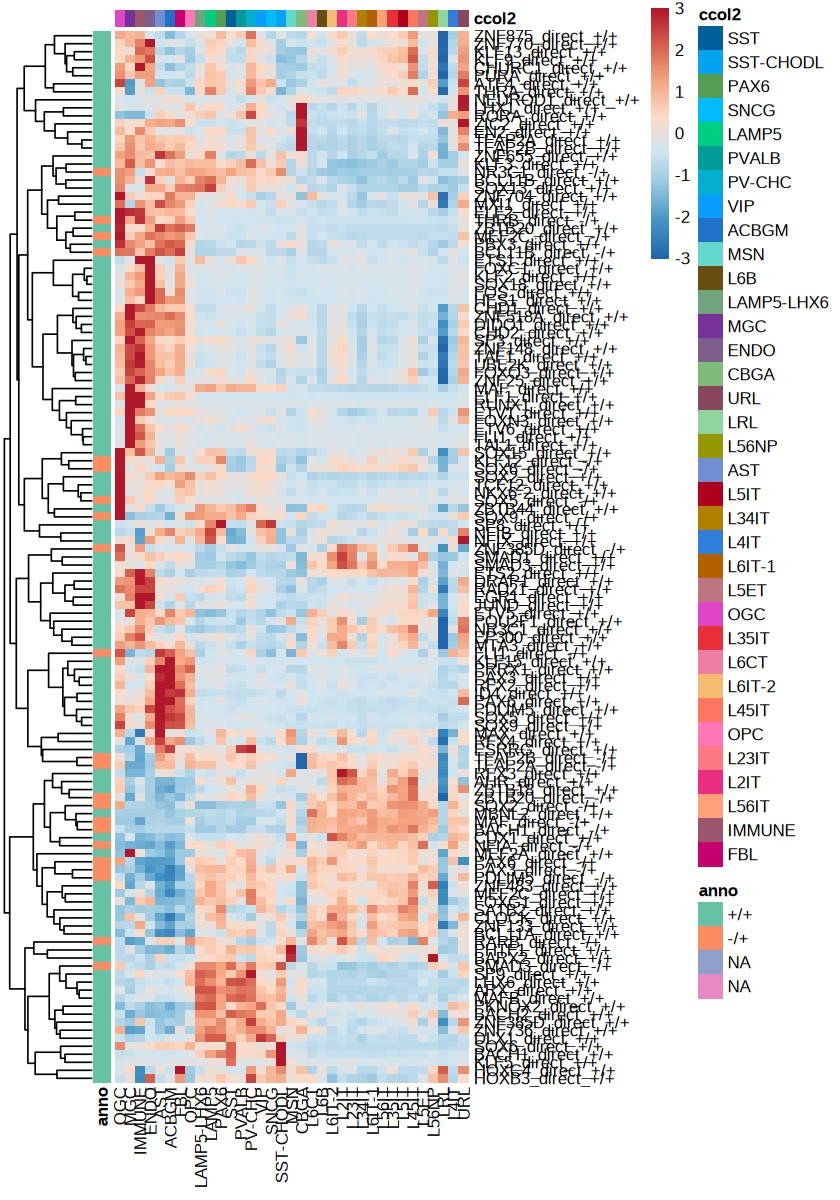

In [39]:
### read subclass level RSS 
group <- 'subclass_corrected'
rss <- read.csv(paste0(group, ".RSS.csv"), row.names = 1, check.names = F)

expr <- read.csv(paste0("../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_250724.subclass.rpkm.txt"), 
                 header = T, sep = "\t", check.name = F)
cpm <- read.csv(paste0("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250722.", group, ".cpm.csv"), 
                header = T, row.names = 1, check.name = F)

qlist <- list()
for (f in unique(egrn$eRegulon_name)){
    qrange <- egrn %>% filter(eRegulon_name == f) %>% select(Region) %>% unlist %>% unique
    score1 <- cpm[qrange, corder] %>% colMeans()
    qgene <- egrn %>% filter(eRegulon_name == f) %>% select(Gene) %>% unlist %>% unique
    score2 <- expr[qgene, corder] %>% colMeans()
    qlist[[f]] <- sqrt(score1*score2) %>% as.data.frame %>% setNames(f)
}

qlist <- do.call(cbind, qlist) %>% t

qcol <- corder
max_indices <- max.col(qlist[, qcol])
permutation_vector <- order(max_indices)
# rmat <- qlist[permutation_vector, qcol]

### column and row annotations:
canno <- data.frame(ccol2 = colnames(rmat))
rownames(canno) <- colnames(rmat)
ranno <- data.frame(anno = gsub(".*.direct_([^\\_]+)", "\\1", rownames(rmat)))
rownames(ranno) <- rownames(rmat)
ncol <- c("#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3")
names(ncol) <- unique(ranno$anno)

annocolor <- list("ccol2" = ccol2, "anno" = ncol)
options(repr.plot.width = 7, repr.plot.height = 10)

t2 <- rmat %>% 
pheatmap::pheatmap(border_color = NA, scale = "row", cluster_rows = T, cluster_cols = F, angle_col = 90, show_rownames = T, 
                   annotation_row = ranno, annotation_col = canno, annotation_colors = annocolor, 
                     breaks = seq(-3, 3, 0.06),
                     color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(100))

## Plot all top active GRNs

[1] 109

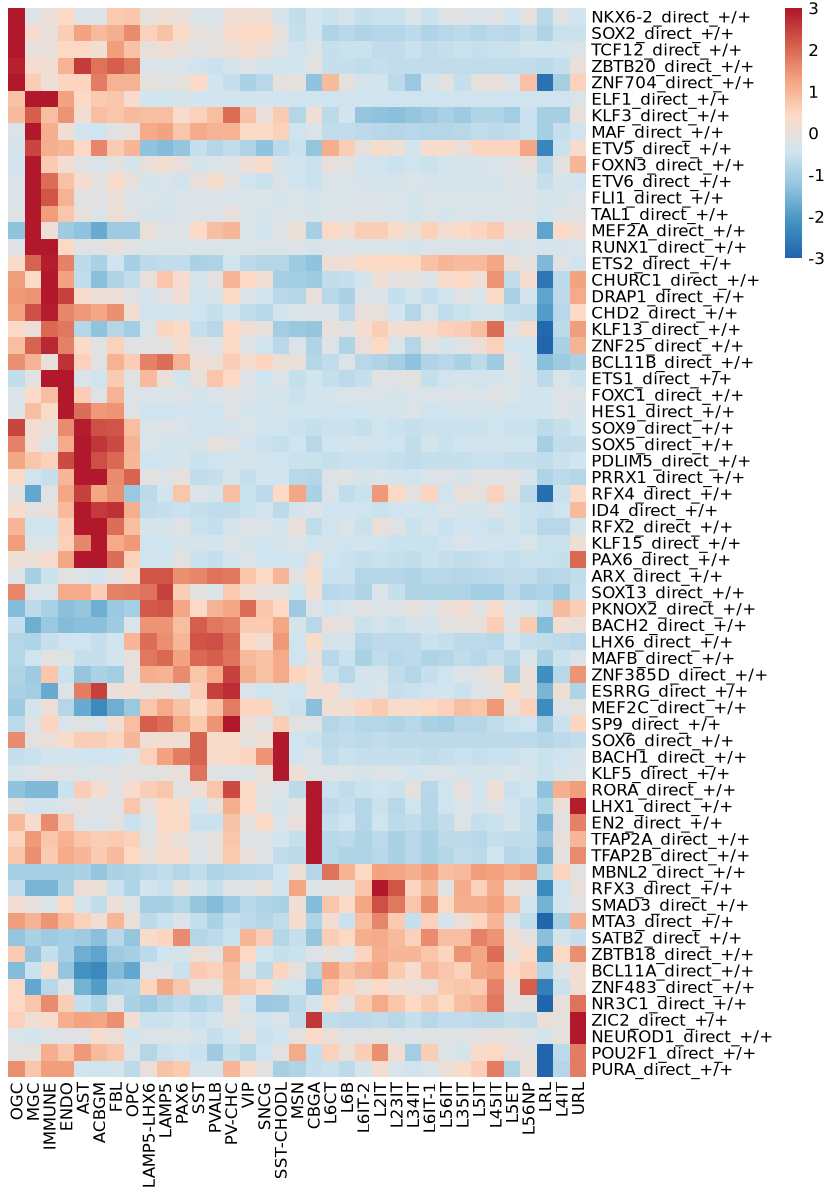

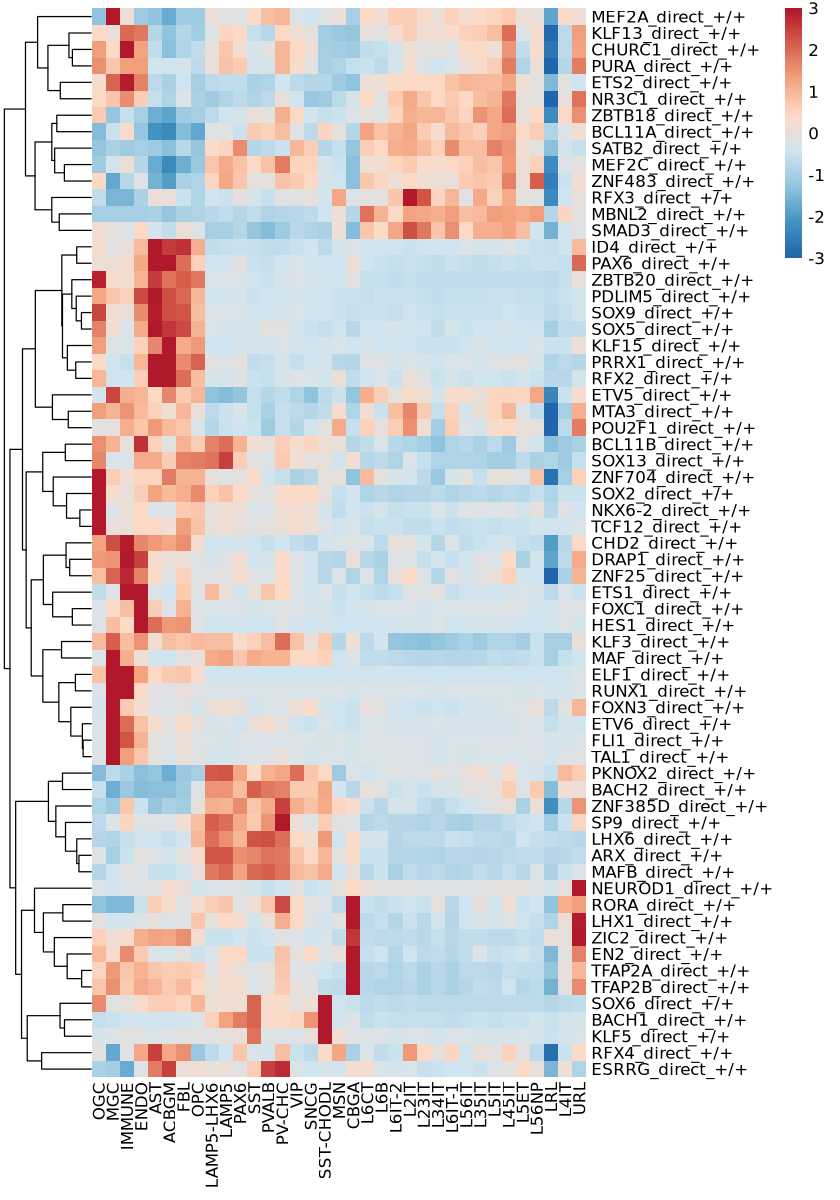

In [23]:
group <- 'subclass_corrected'
rss <- read.csv(paste0(group, ".RSS.csv"), row.names = 1, check.names = F)
grep("\\+\\/\\+", rownames(rss), value = T) %>% length

expr <- read.csv(paste0("../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_250724.subclass.rpkm.txt"), 
                 header = T, sep = "\t", check.name = F)
cpm <- read.csv(paste0("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250722.", group, ".cpm.csv"), 
                header = T, row.names = 1, check.name = F)

qgrn <- grep("\\+\\/\\+", rownames(rss), value = T)
qdf <- egrn %>% filter(Gene_signature_name %in% qgrn)
qlist <- list()
for (f in unique(qdf$eRegulon_name)){
    qrange <- qdf %>% filter(eRegulon_name == f) %>% select(Region) %>% unlist %>% unique
    score1 <- cpm[qrange, corder] %>% colMeans()
    qgene <- qdf %>% filter(eRegulon_name == f) %>% select(Gene) %>% unlist %>% unique
    score2 <- expr[qgene, corder] %>% colMeans()
    qlist[[f]] <- sqrt(score1*score2) %>% as.data.frame %>% setNames(f)
}

qlist <- do.call(cbind, qlist) %>% t
qlist2 <- qlist[paste0(stf, "_direct_+/+"), ]

qcol <- corder
max_indices <- max.col(qlist2[, qcol])
permutation_vector <- order(max_indices)
rmat <- qlist2[permutation_vector, qcol]

options(repr.plot.width = 7, repr.plot.height = 10)
t1 <- rmat %>% 
pheatmap::pheatmap(border_color = NA, scale = "row", cluster_rows = F, cluster_cols = F, angle_col = 90, show_rownames = T, 
         breaks = seq(-3, 3, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(100))

t2 <- rmat %>% 
pheatmap::pheatmap(border_color = NA, scale = "row", cluster_rows = T, cluster_cols = F, angle_col = 90, show_rownames = T, 
         breaks = seq(-3, 3, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(100))

### Cluster level

In [18]:
rss <- read.csv("default_cluster_manual_name.RSS.csv", row.names = 1, check.names = F)
grep("\\+\\/\\+", rownames(rss), value = T) %>% length
nrow(rss)

[1] 112

[1] 249

In [19]:
### Plot GRN activity: sqrt(gene * regions)
expr <- read.csv("../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_250724.cluster_manual_name.rpkm.txt", header = T, sep = "\t")
cpm <- read.csv("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250722.cluster_manual_name.cpm.csv", header = T, row.names = 1)
colnames(expr) <- gsub("\\.", "-", colnames(expr))
colnames(cpm) <- gsub("\\.", "-", colnames(cpm))

In [154]:
qgrn <- grep("\\+\\/\\+", rownames(rss), value = T)
qdf <- egrn %>% filter(Gene_signature_name %in% qgrn)
qlist <- list()
for (f in unique(qdf$eRegulon_name)){
    qrange <- qdf %>% filter(eRegulon_name == f) %>% select(Region) %>% unlist %>% unique
    score1 <- cpm[qrange, corder2] %>% colMeans()
    qgene <- qdf %>% filter(eRegulon_name == f) %>% select(Gene) %>% unlist %>% unique
    score2 <- expr[qgene, corder2] %>% colMeans()
    qlist[[f]] <- sqrt(score1*score2) %>% as.data.frame %>% setNames(f)
}

qlist <- do.call(cbind, qlist) %>% t

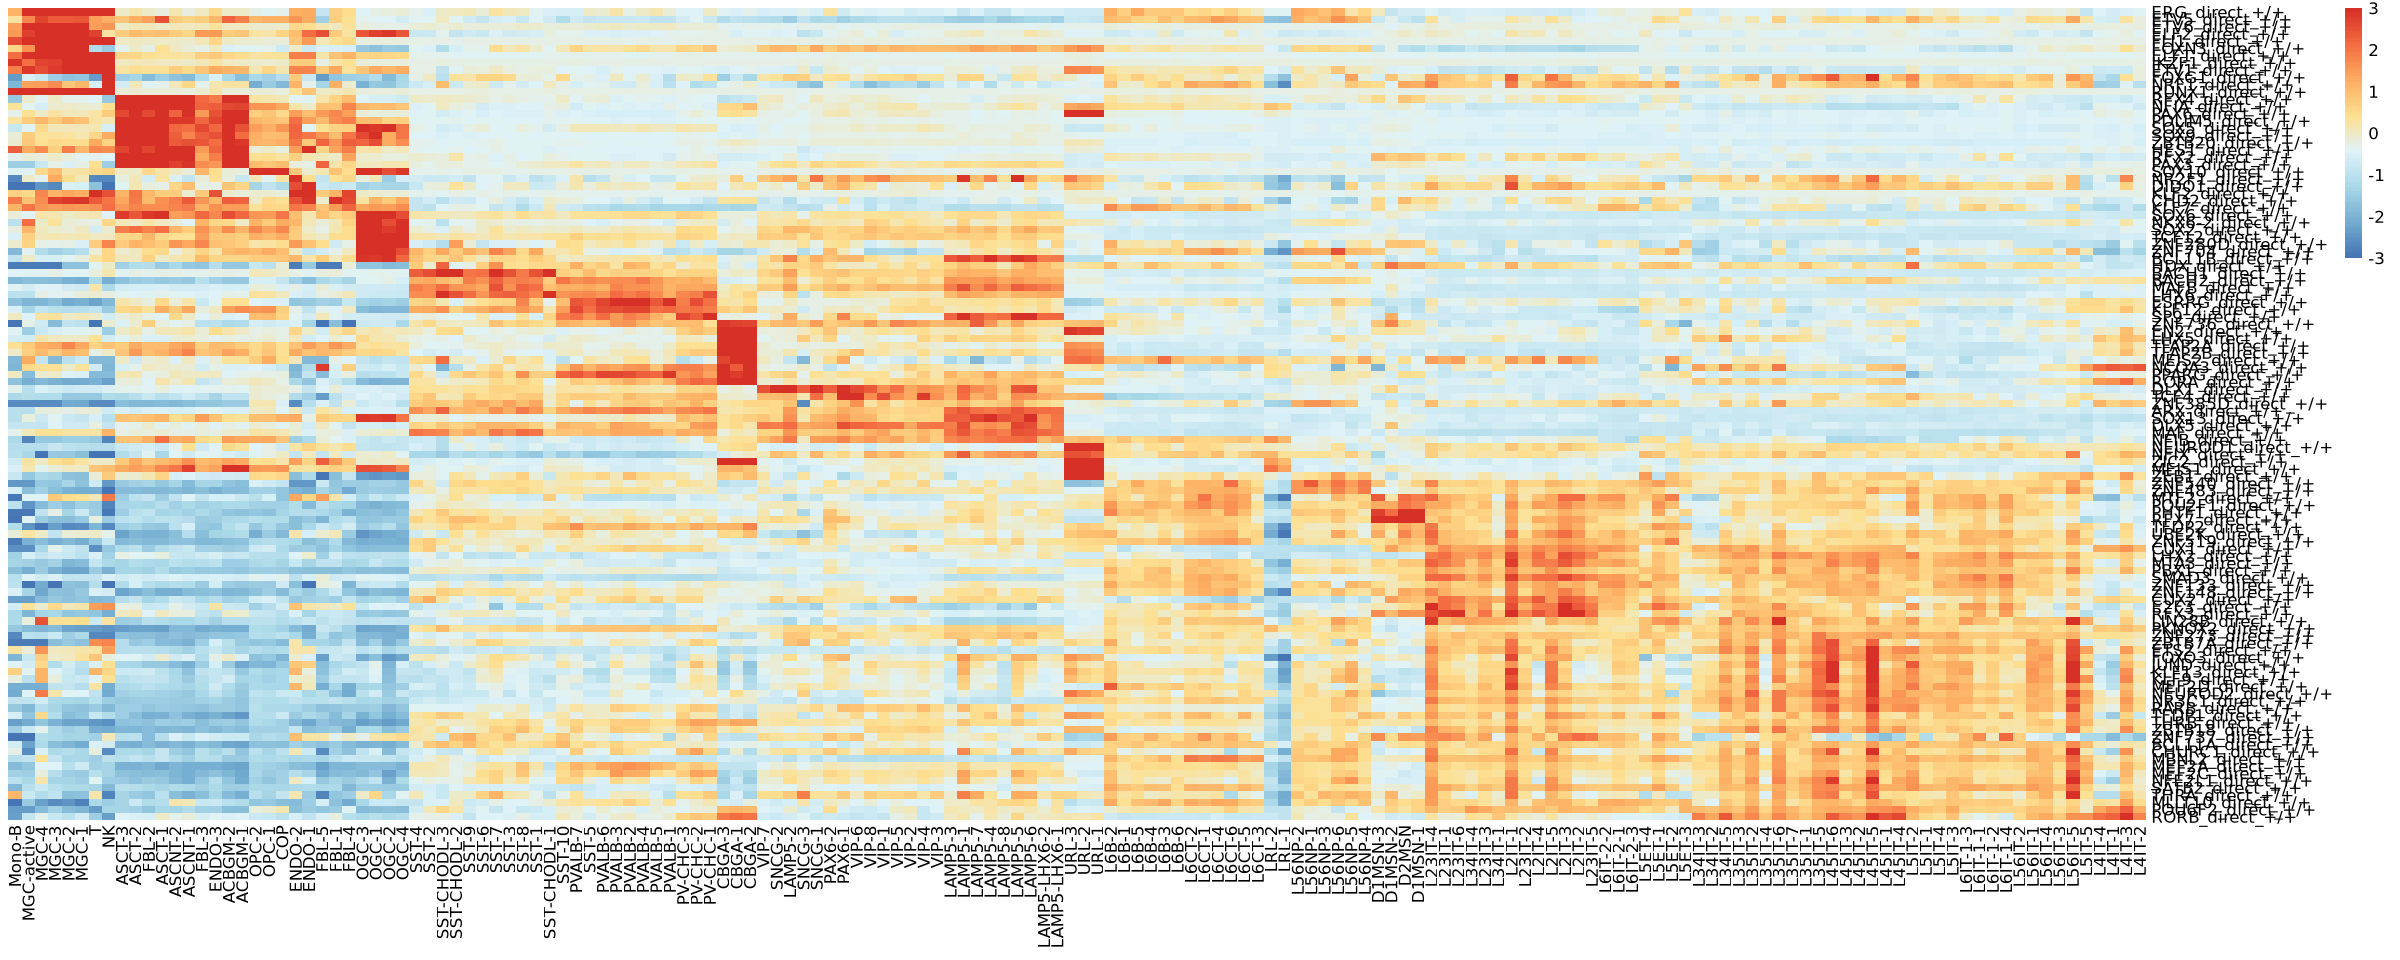

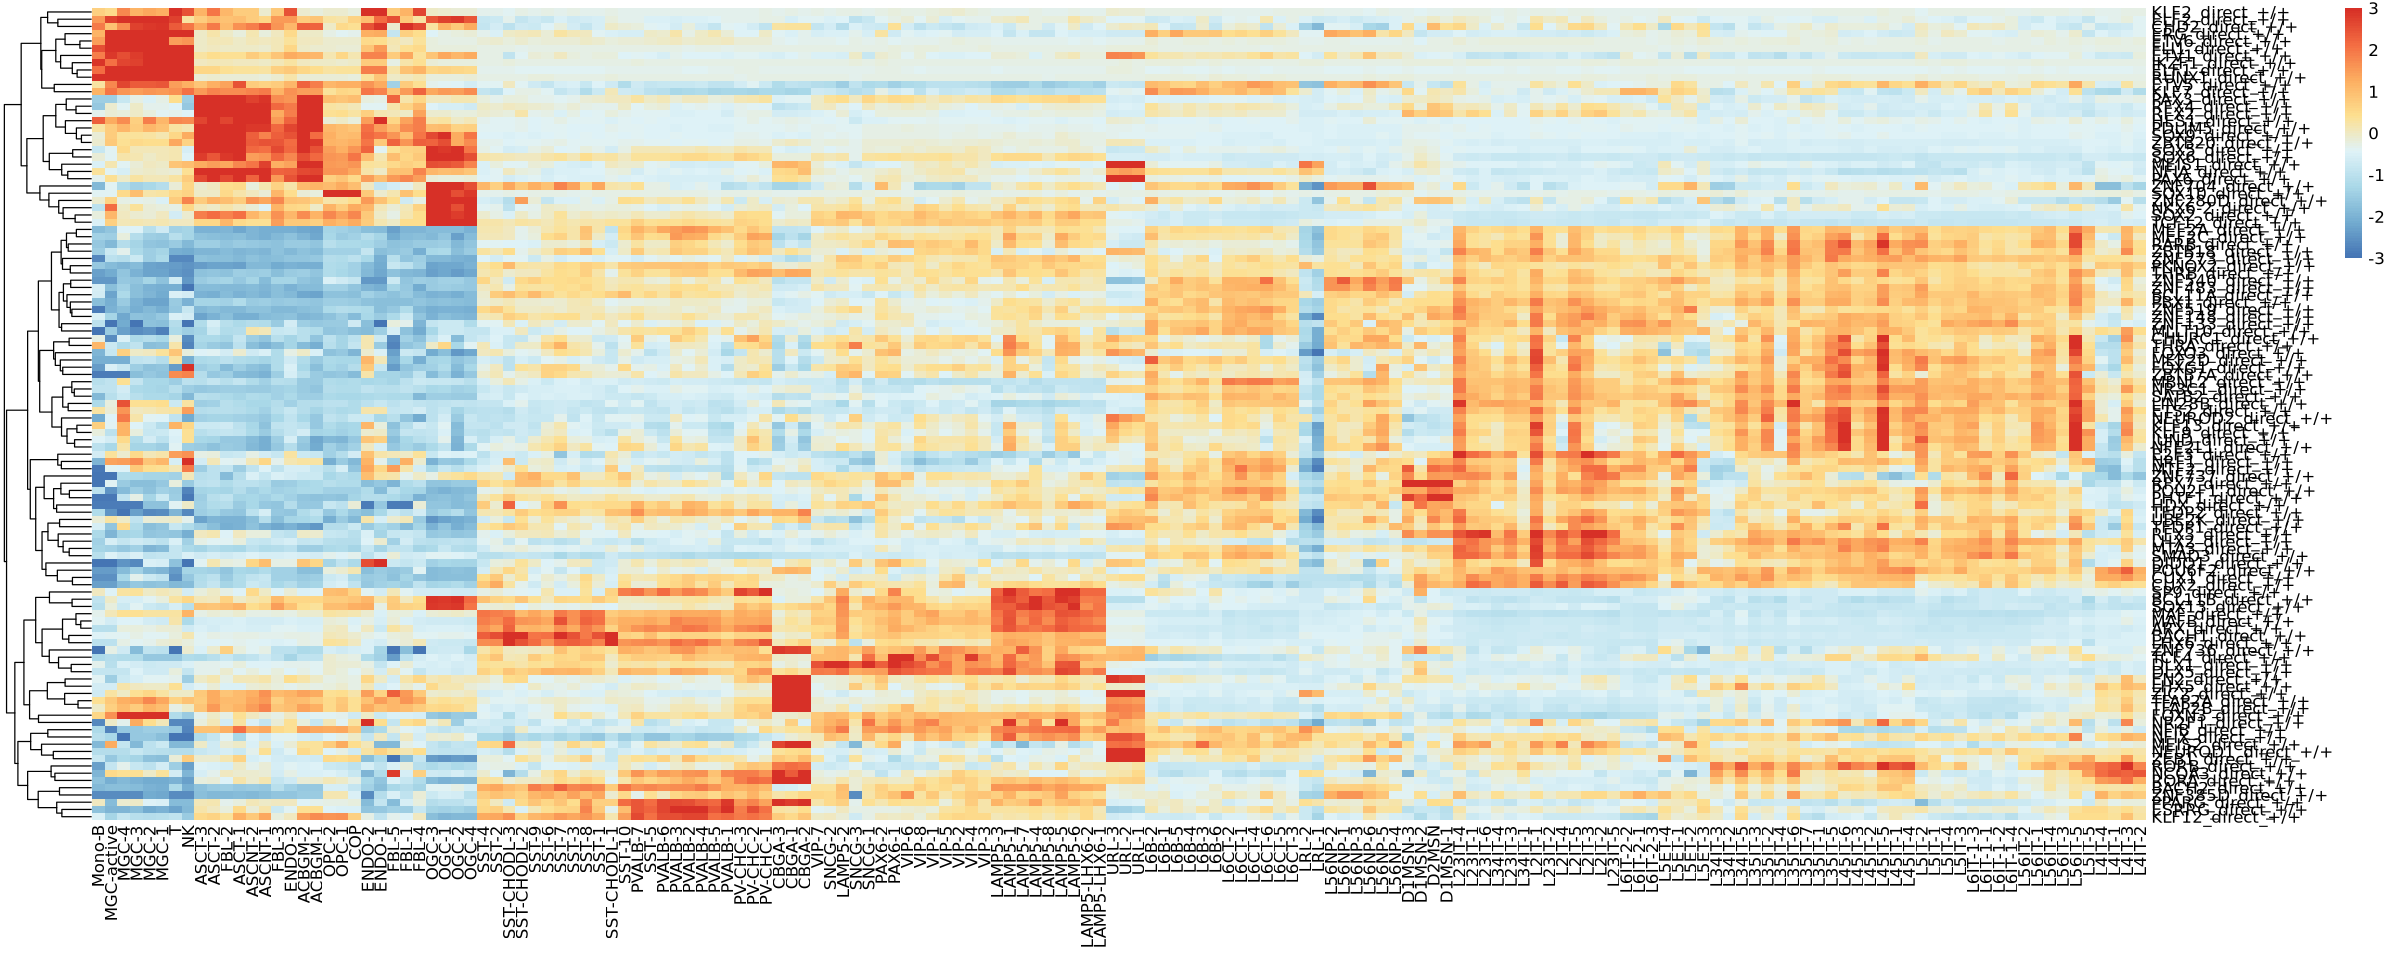

In [155]:
qcol <- corder2 
max_indices <- max.col(qlist[, qcol])
permutation_vector <- order(max_indices)
rmat <- qlist[permutation_vector, qcol]

options(repr.plot.width = 20, repr.plot.height = 8)
t1 <- rmat %>% 
pheatmap::pheatmap(border_color = NA, scale = "row", cluster_rows = F, cluster_cols = F, angle_col = 90, show_rownames = T, 
         breaks = seq(-3, 3, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdYlBu")))(100))

t2 <- rmat %>% 
pheatmap::pheatmap(border_color = NA, scale = "row", cluster_rows = T, cluster_cols = F, angle_col = 90, show_rownames = T, 
         breaks = seq(-3, 3, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdYlBu")))(100))

In [88]:
qtf <- "NFE2L1"
qgene <- egrn %>% filter(TF == qtf) %>% select(Gene) %>% unlist %>% unique
flist <- flist2 <- list()
qres <- clusterProfiler::enrichGO(gene = qgene,
            OrgDb = org.Hs.eg.db::org.Hs.eg.db,
            keyType = 'SYMBOL',
            ont = "BP", # biological process
            pAdjustMethod = "BH", 
            pvalueCutoff = 0.05, 
            qvalueCutoff = 0.05, 
            readable = TRUE)
qres2 <- clusterProfiler::simplify(qres, cutoff=0.7, by="p.adjust", select_fun=min)

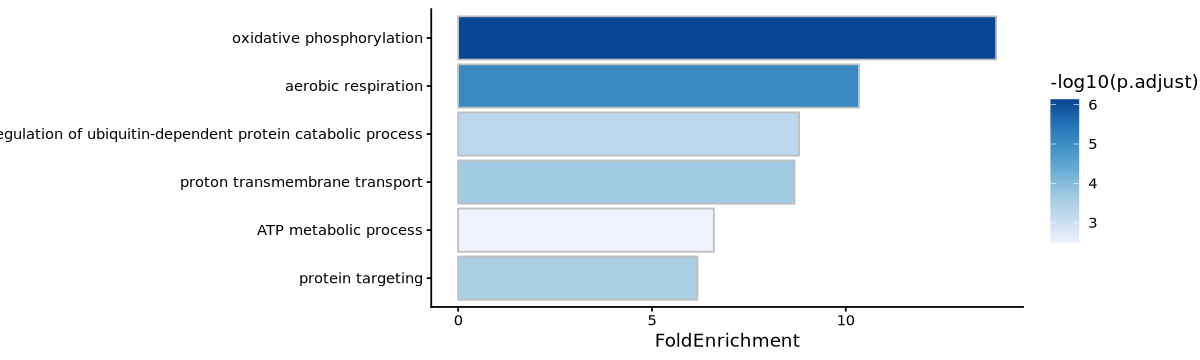

In [112]:
t1 <- qres2@result %>% filter(Count >= 5, Count <= 500) %>% 
slice_max(order_by = -log10(p.adjust), n = 6) %>%
arrange(desc(FoldEnrichment)) %>% 
mutate(Description = factor(Description, levels = rev(Description))) %>%
ggplot(aes(x = FoldEnrichment, y = Description, fill = -log10(p.adjust))) +
geom_col(color = "grey") + 
theme_classic() + ylab("") + 
scale_fill_distiller(direction = 1)

options(repr.plot.width = 10, repr.plot.height = 3)
t1

In [113]:
ggsave(t1, filename = paste0("../Figure/", qtf, "_TF_regulating_genes_enrichGO.pdf"), 
       dpi = 300, height = 3, width = 10)

In [123]:
library(DOSE)
eg = clusterProfiler::bitr(qgene, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
qres <- clusterProfiler::enrichDO(gene = eg$ENTREZID,
ont = "HDO",
pvalueCutoff  = 0.05,
pAdjustMethod = "BH",
qvalueCutoff  = 0.05,
readable = T)
qres@result %>% filter(p.adjust < 0.05)

'select()' returned 1:1 mapping between keys and columns



ID Description GeneRatio BgRatio RichFactor FoldEnrichment zScore pvalue
     p.adjust qvalue geneID Count

In [74]:
qtf <- "NFE2L1"
# egrn <- read.table("scplus_pipeline/Snakemake/default_output/eRegulon_direct.tsv", sep = '\t', header = T)
qgene <- egrn %>% filter(TF == qtf, rho_TF2G >= 0.05, rho_R2G >= 0.05) %>% select(Gene) %>% unlist %>% unique
qgene <- degene %>% filter(FDR < 0.01, abs(logFC) >= 1) %>% filter(gene %in% qgene) %>% select(gene) %>% unlist %>% unique
length(qgene)

[1] 75

In [85]:
qnx <- egrn %>% filter(Gene == "NDUFA13" | TF == qtf) %>% 
filter(rho_TF2G >= 0.05, rho_R2G >= 0.05) %>% 
select(TF, Gene, importance_R2G) %>% 
setNames(c("tf", "target", "importance"))

edges <- qnx %>%
filter(!is.na(tf), !is.na(target), tf != target) %>%
distinct(tf, target, .keep_all = TRUE) %>% 
mutate(interaction = "regulates",
       grn = tf,
       weight = if ("importance" %in% names(.)) importance else 1)

nodes <- tibble(name = unique(c(edges$tf, edges$target))) %>%
mutate(type = ifelse(name %in% edges$tf, "TF", "gene"))

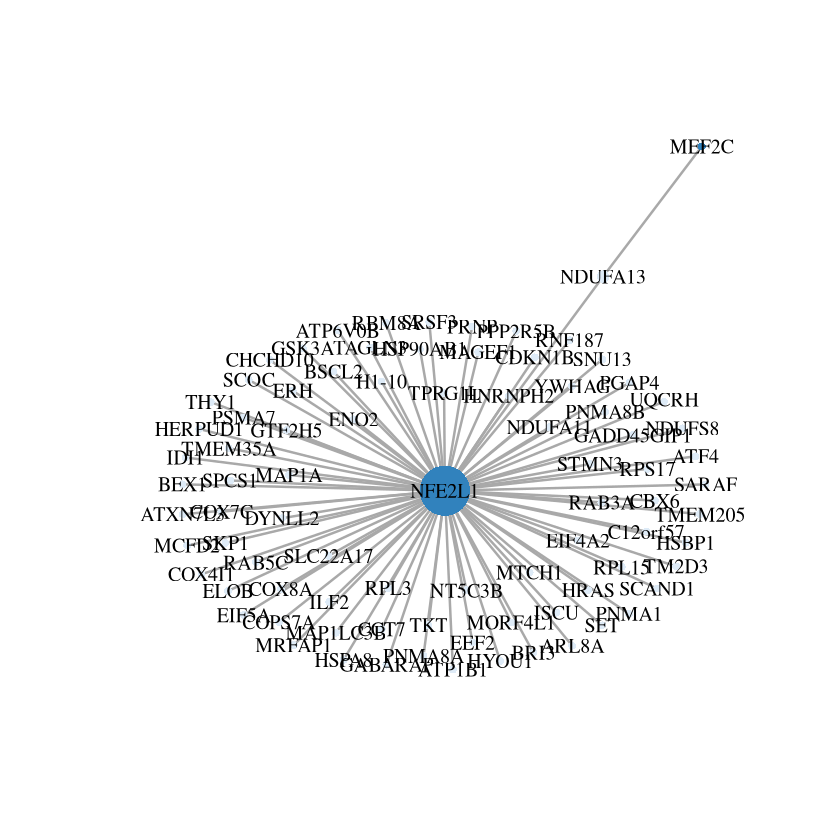

In [87]:
set.seed(921)
g <- igraph::graph_from_data_frame(d = edges %>% select(from=tf, to=target, weight, grn), vertices = nodes, directed = TRUE)
deg <- degree(g, mode="all")
V(g)$size <- 3*log2(deg+1)

cols1 <- colorRampPalette(brewer.pal(11, "RdYlBu"))(10)
cols2 <- colorRampPalette(brewer.pal(3, "Blues"))(2)

V(g)$color <- cols2[as.numeric(factor(V(g)$type))]
# V(g)$color[which(V(g)$type == 'TF')] <- cols1
V(g)$vertex.label.dist <- 5

V(g)$label.color <- "black"
V(g)$vertex.label.cex <- 3	
E(g)$arrow.size <- 0 #.4

# E(g)$color <- cols1[as.numeric(factor(E(g)$grn, levels = V(g)$name[which(V(g)$type == 'TF')]))]
E(g)$width <- 2

graph_attr(g, "layout") <- layout_with_gem #graphopt

options(repr.plot.width = 7, repr.plot.height = 7)
plot(g, vertex.frame.color = NA)

## Plot intereneuron networks

In [496]:
degene <- read.csv("../04.clustering/02.RNA/edgeR_250808/subclass_corrected_edgeR.dds")
deglist <- degene %>% filter(FDR < 0.01, abs(logFC) >= 1) %>% select(gene) %>% unlist %>% as.character %>% unique
dar <- read.csv("../07.cCREs/LRtest/K27ac_hba_ccre_LR.csv")
dme <- read.csv("../07.cCREs/LRtest/K27me3_hba_ccre_5000.csv")

group <- 'subclass_corrected'
rss <- read.csv(paste0(group, ".RSS.csv"), row.names = 1, check.names = F)

qidx <- rss[,setdiff(gaba, c("CBGA", badcelltype))] %>% 
apply(MARGIN = 2, function(x) which(x %in% sort(x, decreasing = T)[1:3])) %>% unlist %>% as.integer %>% unique

qgene = gsub("([^_]+)_.*.", "\\1", grep("+\\/+", rownames(rss)[qidx], value = T))
write.table(qgene, "GABA_top_GRN_exp_rss.txt", sep = '\t', quote = F, row.names = F, col.names = F)

In [497]:
### selec genes based on triplet_rank / dar / deg
qdgene <- degene %>% filter(celltype %in% setdiff(gaba, c("CBGA", badcelltype))) %>% 
filter(logFC >= 1, FDR < 0.01) %>% dplyr::select(gene) %>% unlist %>% unique 

qdregion <- dar %>% filter(subclass_corrected %in% setdiff(gaba, c("CBGA", badcelltype))) %>% 
filter(log2.fold_change. >= 1, adjusted.p.value < 0.05) %>% dplyr::select(feature.name) %>% unlist %>% unique 

qgene <- egrn %>% filter(Gene_signature_name %in% rownames(rss)[qidx]) %>% 
select(Gene) %>% unlist %>% unique
write.table(qgene, "GABA_all_gene_exp_rss.txt", sep = '\t', quote = F, row.names = F, col.names = F)

qgene <- egrn %>% filter(Gene_signature_name %in% rownames(rss)[qidx]) %>% 
filter(triplet_rank < quantile(triplet_rank, 0.1)) %>% 
# filter(Region %in% qdregion, Gene %in% qdgene) %>%
select(Gene) %>% unlist %>% unique
write.table(qgene, "GABA_top_gene_q10triple_rank_exp_rss.txt", sep = '\t', quote = F, row.names = F, col.names = F)

qgene <- egrn %>% filter(Gene_signature_name %in% rownames(rss)[qidx]) %>% 
filter(triplet_rank < quantile(triplet_rank, 0.05)) %>% 
# filter(Region %in% qdregion, Gene %in% qdgene) %>%
select(Gene) %>% unlist %>% unique
write.table(qgene, "GABA_top_gene_q05triple_rank_exp_rss.txt", sep = '\t', quote = F, row.names = F, col.names = F)

qgene <- egrn %>% filter(Gene_signature_name %in% rownames(rss)[qidx]) %>% 
filter(Region %in% qdregion, Gene %in% qdgene) %>%
select(Gene) %>% unlist %>% unique
write.table(qgene, "GABA_top_gene_de_da_exp_rss.txt", sep = '\t', quote = F, row.names = F, col.names = F)

topg <- degene %>% filter(celltype %in% setdiff(gaba, c("CBGA", badcelltype))) %>% 
filter(logFC >= 1, FDR < 0.01) %>% group_by(celltype) %>% slice_max(logFC, n = 50) %>% ungroup %>% unlist %>% unique 
qgene <- egrn %>% filter(Gene_signature_name %in% rownames(rss)[qidx]) %>% 
filter(Gene %in% topg) %>%
select(Gene) %>% unlist %>% unique
write.table(qgene, "GABA_top_gene_de_exp_rss.txt", sep = '\t', quote = F, row.names = F, col.names = F)

In [498]:
topg <- degene %>% filter(celltype %in% setdiff(gaba, c("CBGA", badcelltype))) %>% 
filter(logFC >= 1, FDR < 0.01) %>% group_by(celltype) %>% slice_max(logFC, n = 50) %>% ungroup %>% unlist %>% unique 
qgene <- egrn %>% filter(Gene_signature_name %in% rownames(rss)[qidx]) %>% 
filter(Gene %in% topg) %>%
select(Gene) %>% unlist %>% unique
write.table(qgene, "GABA_top_gene_de_exp_rss.txt", sep = '\t', quote = F, row.names = F, col.names = F)

In [499]:
tgrn <- read.table("GABA_top_GRN_exp_rss.txt")
tgene <- read.table("GABA_top_gene_de_exp_rss.txt")
ftp <- egrn %>% filter(TF %in% tgrn$V1, Gene %in% c(tgrn$V1, tgene$V1)) %>% select(TF, Gene, importance_R2G) %>% 
setNames(c("tf", "target", "importance"))

edges <- ftp %>%
filter(!is.na(tf), !is.na(target), tf != target) %>%
distinct(tf, target, .keep_all = TRUE) %>% 
mutate(interaction = "regulates",
       grn = tf,
       weight = if ("importance" %in% names(.)) importance else 1)

nodes <- tibble(name = unique(c(edges$tf, edges$target))) %>%
mutate(type = ifelse(name %in% edges$tf, "TF", "gene"))

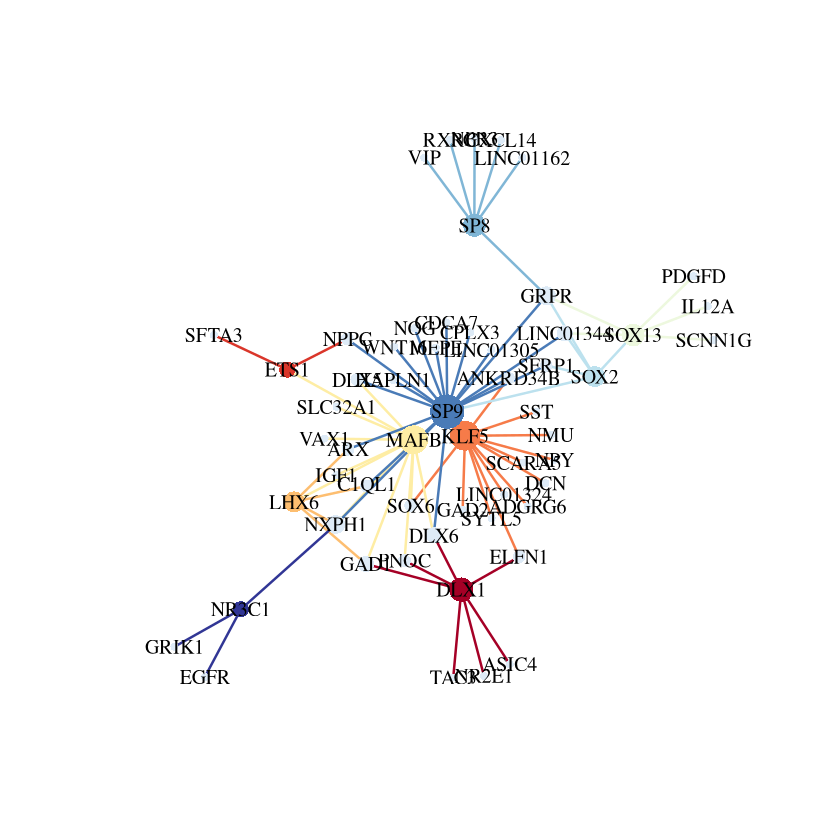

In [500]:
set.seed(921)
g <- igraph::graph_from_data_frame(d = edges %>% select(from=tf, to=target, weight, grn), vertices = nodes, directed = TRUE)
deg <- degree(g, mode="all")
V(g)$size <- 3*log2(deg+1)

cols1 <- colorRampPalette(brewer.pal(11, "RdYlBu"))(10)
cols2 <- colorRampPalette(brewer.pal(3, "Blues"))(2)

V(g)$color <- cols2[as.numeric(factor(V(g)$type))]
V(g)$color[which(V(g)$type == 'TF')] <- cols1
V(g)$vertex.label.dist <- 5

V(g)$label.color <- "black"
V(g)$vertex.label.cex <- 3	
E(g)$arrow.size <- 0 #.4

E(g)$color <- cols1[as.numeric(factor(E(g)$grn, levels = V(g)$name[which(V(g)$type == 'TF')]))]
E(g)$width <- 2

graph_attr(g, "layout") <- layout_with_gem #graphopt

options(repr.plot.width = 7, repr.plot.height = 7)
plot(g, vertex.frame.color = NA)

In [363]:
qidx <- rss[,setdiff(gaba, c("CBGA", badcelltype))] %>% apply(MARGIN = 2, function(x) which(x %in% sort(x, decreasing = T)[1:25])) %>% unlist %>% as.integer %>% unique
qgene = gsub("([^_]+)_.*.", "\\1", grep("+\\/+", rownames(rss)[qidx], value = T))
ftp2 <- ftp %>% filter(pathway %in% qgene)

In [364]:
### Make one more networks
tgene <- read.table("GABA_top_gene_de_exp_rss.txt")
qnx <- egrn %>% 
filter(TF %in% ftp2$pathway, Gene %in% c(ftp2$pathway, tgene$V1)) %>% 
select(TF, Gene, importance_R2G) %>% 
setNames(c("tf", "target", "importance"))
qnx$NES <- ftp2[match(qnx$tf, ftp2$pathway), ]$NES 

edges <- qnx %>%
filter(!is.na(tf), !is.na(target), tf != target) %>%
distinct(tf, target, .keep_all = TRUE) %>% 
mutate(interaction = "regulates",
       grn = tf, NES = NES,
       weight = if ("importance" %in% names(.)) importance else 1)

nodes <- tibble(name = unique(c(edges$tf, edges$target))) %>%
mutate(type = ifelse(name %in% edges$tf, "TF", "gene"))

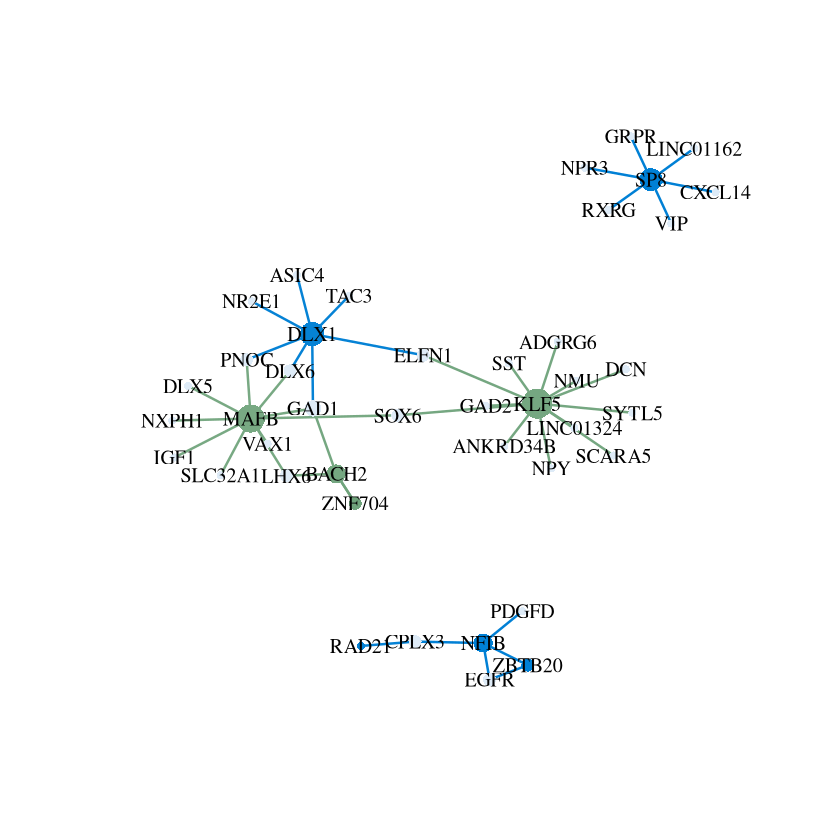

In [371]:
set.seed(910)
g <- igraph::graph_from_data_frame(d = edges %>% select(from=tf, to=target, weight, grn, NES), vertices = nodes, directed = TRUE)

pal <- colorRampPalette(c('#70a47c', 'white', '#0080d5'))
lut <- pal(100) 
rng <- range(E(g)$NES, na.rm = TRUE)
idx <- round(scales::rescale(E(g)$NES, to = c(1, 100), from = rng))
cols1 <- lut[idx]
cols1[is.na(cols1)] <- "grey85"
cdf <- data.frame(cols1, E(g)$NES, E(g)$grn) %>%
distinct %>% setNames(c("color", "NES", "grn"))

cols2 <- colorRampPalette(brewer.pal(3, "Blues"))(2)

### specify color
deg <- degree(g, mode="all")
V(g)$size <- 3*log2(deg+1)
V(g)$color <- cols2[as.numeric(factor(V(g)$type))]

### color node and edge by NES or TF
V(g)$color[which(V(g)$type == 'TF')] <- cdf[match(V(g)$name[which(V(g)$type == 'TF')], cdf$grn),]$color
V(g)$vertex.label.dist <- 15

V(g)$label.color <- "black"
V(g)$vertex.label.cex <- 3	
E(g)$arrow.size <- 0 #.4

E(g)$color <- cols1 # cols1[as.numeric(factor(E(g)$grn, levels = V(g)$name[which(V(g)$type == 'TF')]))]
E(g)$width <- 2

graph_attr(g, "layout") <- layout_with_graphopt

options(repr.plot.width = 7, repr.plot.height = 7)
plot(g, vertex.frame.color = NA)

In [380]:
set.seed(910)
pdf("../Figure/MGE_CGE_fGSEA_GRN.pdf", width = 7, height = 7)
plot(g, vertex.frame.color = NA)
dev.off()

pdf 
  2

In [56]:
### check specifically MGE / CGE
ranked_genes <- read.table("/projects/ps-renlab2/y2xie/projects/BICAN/analysis/04.clustering/02.RNA/edgeR_251021_GABA/supercluster_manual__edgeR_CGE-interneuron_vs_MGE-interneuron.tsv") %>% 
tibble::rownames_to_column("feature") %>%
mutate(rank = -log10(FDR) * logFC) %>%
arrange(desc(rank)) %>% 
dplyr::select(feature, rank) %>% tibble::deframe()
    
fgsea_results <- fgseaMultilevel(pathways = grnlist, stats = ranked_genes, minSize = 5, maxSize = 2000, BPPARAM = BPPARAM)
fgsea_results %>% filter(padj < 0.05)

Warning message in fgseaMultilevel(pathways = grnlist, stats = ranked_genes, minSize = 5, :
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


pathway pval         padj         log2err   ES         NES       size
1  BACH2   2.425683e-05 5.239475e-04 0.5756103 -0.8174144 -1.755795 130 
2  DLX1    1.804672e-03 1.771860e-02 0.4550599  0.9440115  1.425085  27 
3  ESRRG   1.744868e-04 2.692082e-03 0.5188481 -0.8152477 -1.690189  97 
4  ETV6    1.441381e-04 2.594486e-03 0.5188481 -0.8812901 -1.690874  61 
5  KLF5    9.342880e-06 3.222739e-04 0.5933255 -0.8880945 -1.749207  78 
6  MAFB    1.193607e-05 3.222739e-04 0.5933255 -0.9352193 -1.732525  48 
7  NFIB    2.963883e-03 2.522962e-02 0.4317077  0.9068604  1.430304  42 
8  PAX6    1.090862e-03 1.178131e-02 0.4550599  0.8633239  1.473148  85 
9  PDLIM5  4.190704e-03 3.017307e-02 0.4070179  0.7470926  1.392609 258 
10 RAD21   6.253189e-04 7.503827e-03 0.4772708  0.7519376  1.424754 348 
11 RFX2    6.302284e-03 4.003804e-02 0.4070179  0.8437157  1.413774  72 
12 SOX13   3.953841e-03 3.017307e-02 0.4070179  0.9493469  1.379732  19 
13 SP8     5.900256e-04 7.503827e-03 0.4772708  0.9484657  1.437402  30 
14 UBE2K   3.388975e-07 1.830047e-05 0.6749629 -0.6427198 -1.588537 516 
15 ZBTB20  3.036899e-03 2.522962e-02 0.4317077  0.8597892  1.447484  73 
16 ZNF148  4.616413e-03 3.116079e-02 0.4070179 -0.4656810 -1.186082 725 
17 ZNF704  1.557434e-08 1.682029e-06 0.7337620 -0.7922487 -1.870828 250 
   leadingEdge 
1  LHX6, SL....
2  PROX1, P....
3  TTC39A, ....
4  CUX2, PR....
5  SOX6, RS....
6  LHX6, SO....
7  CPLX3, M....
8  CBLN1, H....
9  HEPH, MI....
10 CPLX3, L....
11 MAPK4, P....
12 GRPR, PK....
13 CXCL14, ....
14 GAS2, ND....
15 NFIB, BM....
16 SPATS2L,....
17 RSPO3, S....

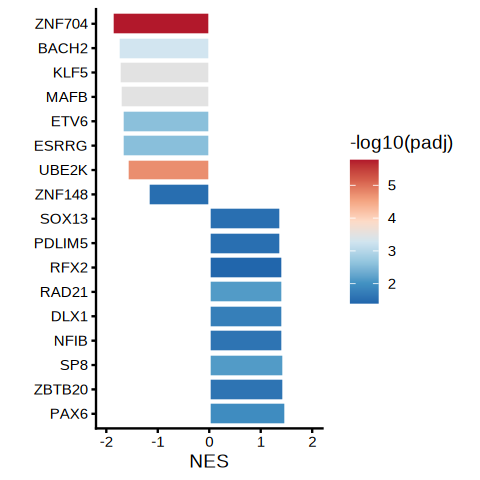

In [58]:
t1 <- fgsea_results %>% 
filter(padj < 0.05) %>%
arrange(desc(NES)) %>% mutate(pathway = factor(pathway, levels = pathway)) %>%
ggplot(aes(x = NES, y = pathway, fill = -log10(padj))) +
geom_col(color = "white") + 
theme_classic() + ylab("") + xlim(-2, 2) + 
scale_fill_gradientn(colours = rev(brewer.pal(n = 8, name = "RdBu")), oob = squish)

options(repr.plot.width = 4, repr.plot.height = 4)
t1

In [141]:
library(anndata)
gauc <- read_h5ad("scplus_pipeline/Snakemake/direct_gene_based_AUC.h5ad")
rauc <- read_h5ad("scplus_pipeline/Snakemake/direct_region_based_AUC.h5ad")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Warning message:
“Assay RNA changing from Assay5 to Assay”
Warning message:
“Adding a dimensional reduction (umap) without the associated assay being present”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“annotation$theme is not a valid theme.
Please use `theme()` to construct themes.”


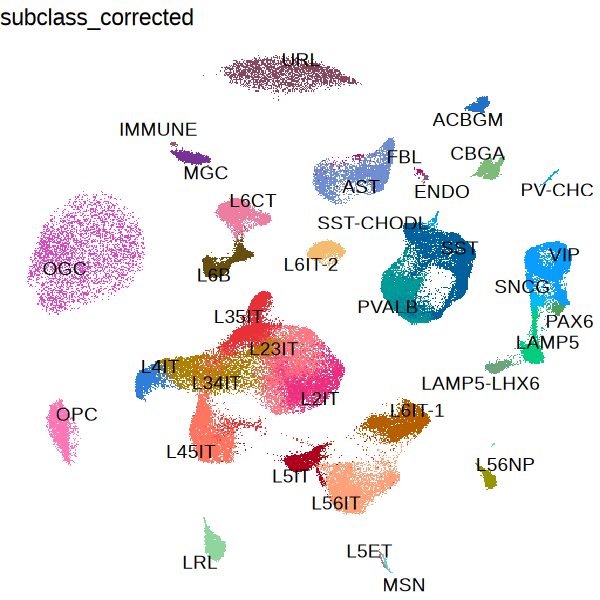

In [143]:
dmeta <- rmeta
dmeta$rna_bc <- rownames(dmeta)
rownames(dmeta) <- paste0(dmeta$dna, ":", dmeta$atac_bc)
obj <- CreateSeuratObject(t(gauc$X), meta.data = dmeta[gauc$obs_names, ], assay = "RNA")
obj[["RNA"]] <- CreateAssayObject(counts = obj[["RNA"]]$counts)

qumap <- rumap[obj$rna_bc, ]
rownames(qumap) <- colnames(obj)
obj[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(qumap), key = "UMAP_", assay = "peaks")

options(repr.plot.width = 5, repr.plot.height = 5)
DimPlot(obj, group.by = "subclass_corrected", reduction = "umap", 
        cols = ccol2, label = T, repel = T) & theme_void() + NoLegend()

In [269]:
options(repr.plot.width = 15, repr.plot.height = 5)
FeaturePlot(obj, features = grep(paste0(c("SP8", "SP9", "KLF5"), collapse = "|"), rownames(obj), value = T), 
            reduction = "umap", label = F, repel = T, max.cutoff = 'q90') & scale_color_distiller(direction = 1)

ERROR: Error: object 'obj' not found


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


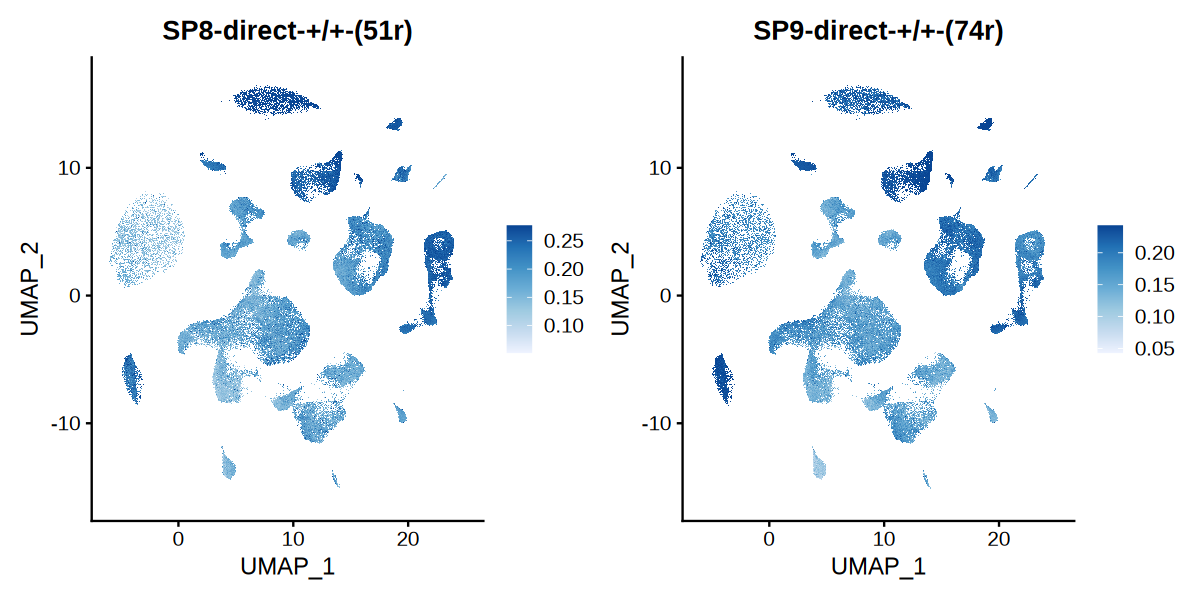

In [151]:
# obj2 <- CreateSeuratObject(t(rauc$X), meta.data = dmeta[rauc$obs_names, ], assay = "RNA")
# obj2[["RNA"]] <- CreateAssayObject(counts = obj2[["RNA"]]$counts)
# obj2[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(qumap), key = "UMAP_", assay = "peaks")

options(repr.plot.width = 10, repr.plot.height = 5)
FeaturePlot(obj2, features = grep(paste0(c("SP8", "SP9"), collapse = "|"), rownames(obj2), value = T), 
            reduction = "umap", label = F, repel = T, max.cutoff = 'q90') & scale_color_distiller(direction = 1)

In [150]:
qs::qsave(obj, "MiniAtlas_H3K27ac_scenicplus_direct_gene_based_AUC.qs")
qs::qsave(obj2, "MiniAtlas_H3K27ac_scenicplus_direct_region_based_AUC.qs")

### Plot MGE/CGE UMAP and representative GRNs

In [ ]:
library(anndata)
gauc <- read_h5ad("scplus_pipeline/Snakemake/direct_gene_based_AUC.h5ad")
rauc <- read_h5ad("scplus_pipeline/Snakemake/direct_region_based_AUC.h5ad")

dmeta <- rmeta
dmeta$rna_bc <- rownames(dmeta)
rownames(dmeta) <- paste0(dmeta$dna, ":", dmeta$atac_bc)

Warning message:
“Assay RNA changing from Assay5 to Assay”


Perform log CPM normalization...


Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


Perform variable features selection using Brennecke's method...
number of variable genes calculated by hicat method: 3977


Warning message:
“Overwriting miscellanous data for hicat_vg”


Perform data scaling and PCA...


Centering and scaling data matrix



[1] "Downsample PC matrix to 25000 cells to calculate significant PC components"
Number of PC selected for downstream analysis: 50


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



Number of neighbors selected for downstream analysis: 15
Perform UMAP embedding...
resolution used for leiden clustering: 1


Warning message:
“Assay RNA changing from Assay to Assay5”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“annotation$theme is not a valid theme.
Please use `theme()` to construct themes.”


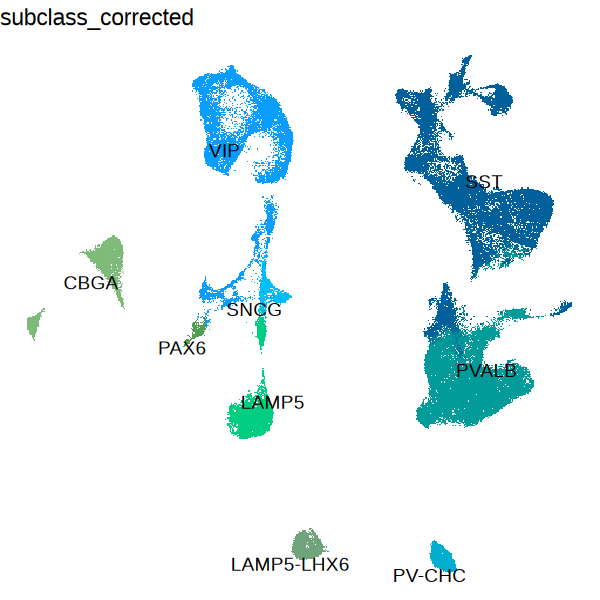

In [160]:
obj <- qs::qread("../12.heterogenity/seurat_objects/MiniAtlas_ctx_cb_GABA.250920.qs")
obj <- subset(obj, subset = subclass_corrected %in% setdiff(gaba, badcelltype))
obj[["RNA"]] <- as(obj[["RNA"]], "Assay")
obj <- seurat_onestep_clust(obj, batch.label = "donor", res = 1)

options(repr.plot.width = 5, repr.plot.height = 5)
DimPlot(obj, group.by = "subclass_corrected", reduction = "umap", 
        cols = ccol2, label = T, repel = T) & theme_void() + NoLegend()
qs::qsave(obj, "../12.heterogenity/seurat_objects/MiniAtlas_ctx_cb_GABA.250920.qs")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


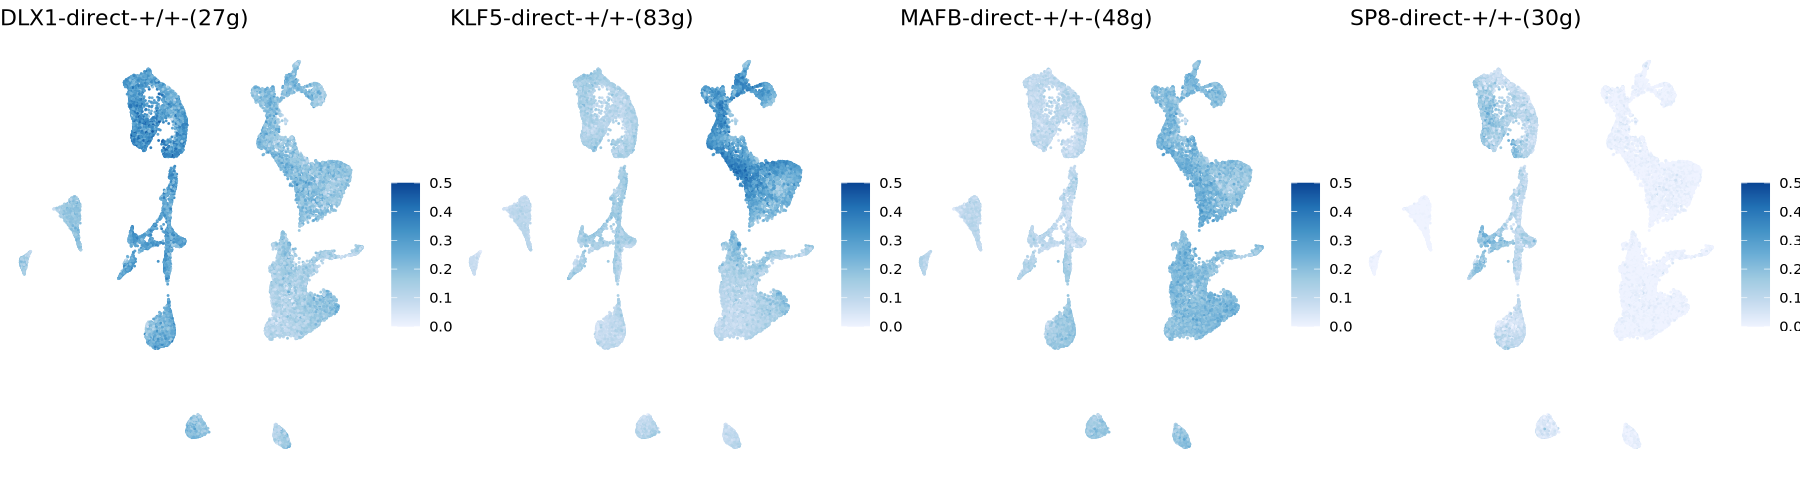

In [77]:
### Plot eregulon AUC
qcell <- dmeta[gauc$obs_names, ] %>% filter(rna_bc %in% colnames(tmp)) %>% rownames
obj <- CreateSeuratObject(t(gauc$X)[,qcell], meta.data = dmeta[qcell, ], assay = "RNA")
obj[["RNA"]] <- CreateAssayObject(counts = obj[["RNA"]]$counts)

qumap <- tmp@reductions$umap@cell.embeddings[obj$rna_bc, ]
rownames(qumap) <- colnames(obj)
obj[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(qumap), key = "UMAP_", assay = "peaks")

fig1 <- FeaturePlot(obj, features = grep(paste0(c("SP8", "DLX1", "KLF5", "MAFB"), collapse = "|"), rownames(obj), value = T), 
            reduction = "umap", label = F, repel = T, ncol = 4) & scale_color_distiller(direction = 1, limits = c(0, 0.5), oob = scales::squish) & theme_void() # & NoLegend()
options(repr.plot.width = 15, repr.plot.height = 4)
fig1

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


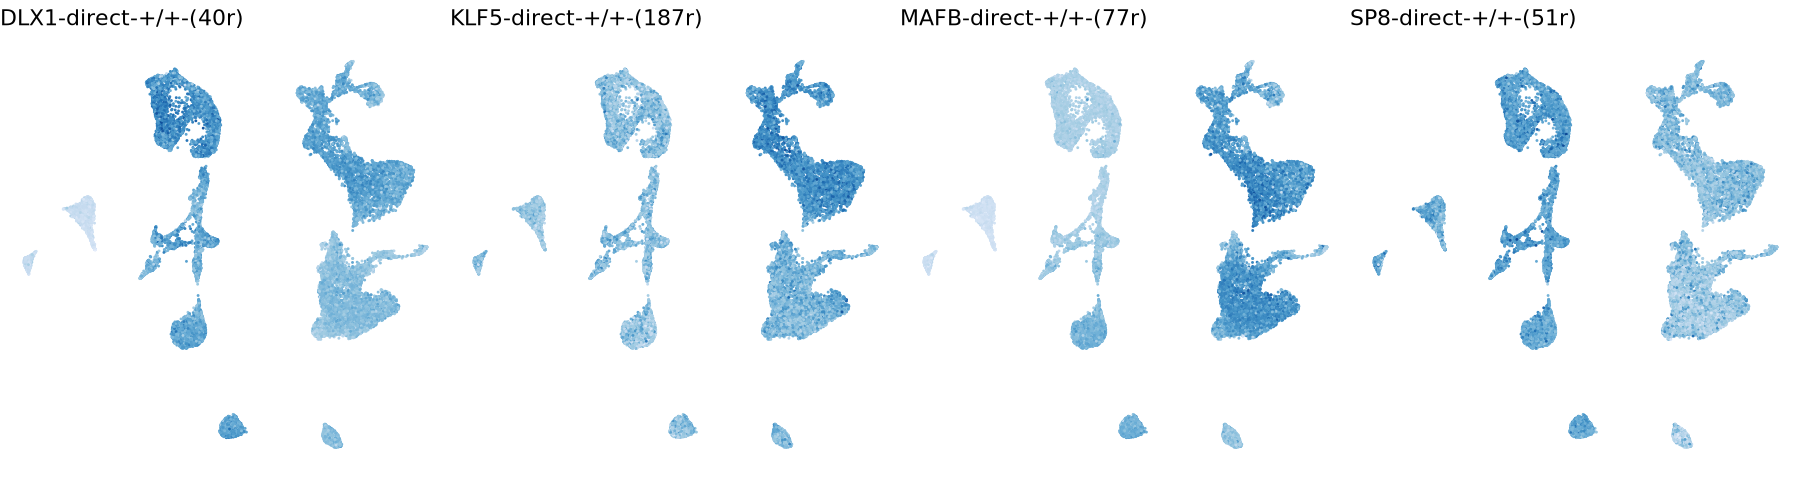

In [400]:
### Plot eregulon AUC: region
obj2 <- CreateSeuratObject(t(rauc$X)[,qcell], meta.data = dmeta[qcell, ], assay = "RNA")
obj2[["RNA"]] <- CreateAssayObject(counts = obj2[["RNA"]]$counts)
obj2[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(qumap), key = "UMAP_", assay = "peaks")

obj2 <- qs::qread("MiniAtlas_H3K27ac_GABA_valid_scenicplus_direct_region_based_AUC.qs")
options(repr.plot.width = 15, repr.plot.height = 4)
FeaturePlot(obj2, features = grep(paste0(c("SP8", "DLX1", "KLF5", "MAFB"), collapse = "|"), rownames(obj2), value = T), 
            reduction = "umap", label = F, repel = T, ncol = 4) & scale_color_distiller(direction = 1) & theme_void() & NoLegend()

## H3K27me3 scenic+

Region                    Gene      importance_R2G rho_R2G   
1 chr14:74954227-74954726   MLH3      0.14057650     0.06740292
2 chr10:117905582-117906081 RAB11FIP2 0.06373071     0.09355922
  importance_x_rho importance_x_abs_rho TF   is_extended eRegulon_name  
1 0.009475267      0.009475267          AFF4 False       AFF4_direct_+/+
2 0.005962596      0.005962596          AFF4 False       AFF4_direct_+/+
  Gene_signature_name    Region_signature_name  importance_TF2G regulation
1 AFF4_direct_+/+_(105g) AFF4_direct_+/+_(101r) 2.193909        1         
2 AFF4_direct_+/+_(105g) AFF4_direct_+/+_(101r) 2.301571        1         
  rho_TF2G   triplet_rank
1 0.09107269 1142        
2 0.12445912 7387

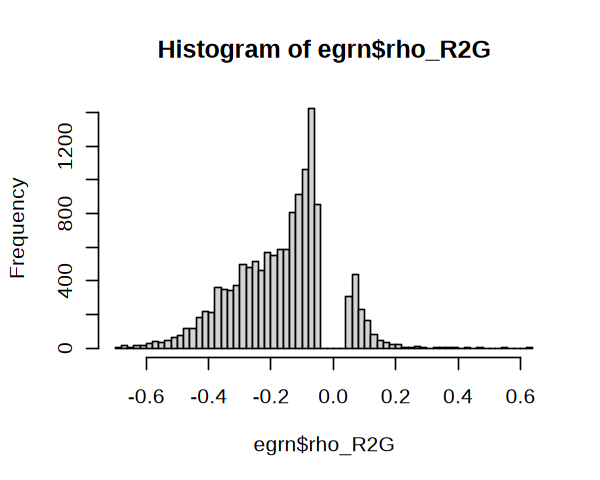

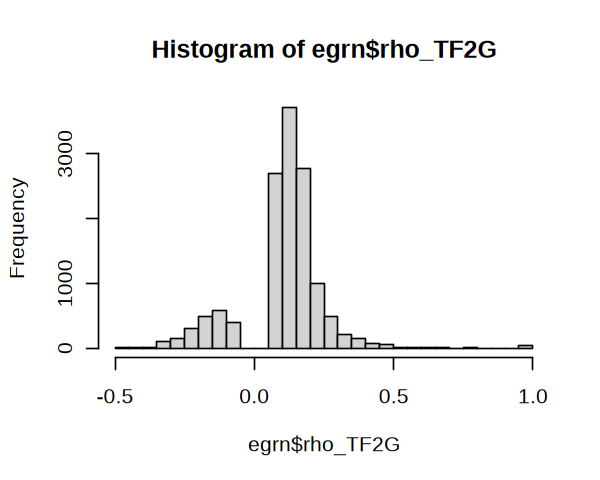

In [62]:
egrn <- read.table("scplus_me3_pipeline/Snakemake/workflow/eRegulon_direct.tsv", sep = '\t', header = T)
head(egrn, 2)

options(repr.plot.width = 5, repr.plot.height = 4)
hist(egrn$rho_R2G, breaks = 50)
hist(egrn$rho_TF2G, breaks = 50)

### For H3K27me3: TF2Gene, R2G needs to be negative (TF2R positive)

In [248]:
rss1 <- read.csv("me3_subclass_corrected.RSS.csv", row.names = 1)
rss2 <- read.csv("me3_subclass_corrected.region.RSS.csv", row.names = 1)
rownames(rss1) <- gsub("(.*)_\\(.*", "\\1", rownames(rss1))
rownames(rss2) <- gsub("(.*)_\\(.*", "\\1", rownames(rss2))

rdf <- list()
for (f in colnames(rss1)){
    share <- intersect(rownames(rss1), rownames(rss2))
    rdf[[f]] <- data.frame(celltype = f, cor = cor(rss1[share, f], rss2[share, f]))
}

rdf <- do.call(rbind, rdf)
summary(rdf)

   celltype              cor          
 Length:35          Min.   :-0.46992  
 Class :character   1st Qu.:-0.32940  
 Mode  :character   Median :-0.26417  
                    Mean   :-0.26361  
                    3rd Qu.:-0.19985  
                    Max.   : 0.01087  

In [311]:
rss <- read.csv("me3_subclass_corrected.RSS.csv", row.names = 1)
colnames(rss) <- gsub("\\.", "-", colnames(rss))
nrow(rss)

grep("\\+\\/\\+", rownames(rss), value = T) %>% unique %>% length ### TF pos with gene; H3K27me3 pos with gene
grep("\\+\\/\\-", rownames(rss), value = T) %>% unique %>% length ### TF pos with gene; H3K27me3 neg with gene. expected inhibited enhancers
grep("\\-\\/\\+", rownames(rss), value = T) %>% unique %>% length ### TF neg with gene; H3K27me3 pos with gene
grep("\\-\\/\\-", rownames(rss), value = T) %>% unique %>% length ### TF neg with gene; H3K27me3 neg with gene. Expected silencer

[1] 125

[1] 29

[1] 74

[1] 2

[1] 20

In [313]:
tf1 <- grep("\\+\\/\\-", rownames(rss), value = T) %>% unique
grep(paste0(gsub("([^_]+)_.*", "\\1", tf1), collapse = "|"), colnames(rss2))

[1] "AHR"     "CBFA2T2" "CHD1"    "CHD2"    "CUX1"    "CUX2"    "DLX1"   
 [8] "DRAP1"   "E2F3"    "EMX1"    "EN2"     "ETV5"    "FOXN3"   "GLIS1"  
[15] "HES1"    "HNF4G"   "HOXB3"   "HOXD3"   "KDM5A"   "KLF12"   "KLF13"  
[22] "KLF5"    "KLF6"    "KLF7"    "KLF9"    "LHX1"    "LHX6"    "LIN28B" 
[29] "MAZ"     "MBD2"    "MEIS1"   "MLLT10"  "MTA3"    "NFIA"    "NFIB"   
[36] "NFIX"    "NKX6-2"  "NR3C1"   "NRF1"    "PAX3"    "PAX6"    "PBX1"   
[43] "PDLIM5"  "PKNOX2"  "POU2F1"  "POU6F2"  "PRRX1"   "RAD21"   "RARB"   
[50] "SATB2"   "SMAD1"   "SMAD3"   "SREBF2"  "STAT1"   "TAF1"    "TCF4"   
[57] "TFAP2A"  "TFAP2B"  "THRA"    "THRB"    "UBE2K"   "VPS4B"   "ZBTB18" 
[64] "ZBTB44"  "ZIC1"    "ZIC2"    "ZNF148"  "ZNF37A"  "ZNF385D" "ZNF423" 
[71] "ZNF519"  "ZNF704"  "ZNF736"  "ZNF737"

In [228]:
### Plot GRN activity: (1-minmax(gene)) * region
expr <- read.csv("../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_250724.subclass.rpkm.txt", header = T, sep = "\t")
cpm <- read.csv("../07.cCREs/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250722.subclass_corrected.cpm.csv", header = T, row.names = 1)
colnames(expr) <- gsub("\\.", "-", colnames(expr))
colnames(cpm) <- gsub("\\.", "-", colnames(cpm))

In [292]:
### test significance
library(fgsea)
library(BiocParallel)
BPPARAM <- MulticoreParam(workers = 16) 

tfr <- grep("_direct_\\-\\/\\-", egrn$eRegulon_name, value = T) %>% unique
tfr <- gsub("_direct_\\-\\/\\-", "", tfr)
length(tfr)

grnlist <- list()
for (tf in tfr){
    grnlist[[tf]] <- egrn %>% 
    filter(eRegulon_name == paste0(tf, "_direct_-/-")) %>% dplyr::select(Gene) %>% unlist %>% unique
}

fgsea_results <- list()
for (f in colnames(ncorder)){
    ranked_genes <- read.table(paste0("/projects/ps-renlab2/y2xie/projects/BICAN/analysis/04.clustering/02.RNA/edgeR_250808/subclass_corrected_edgeR_", f, "_vs_all.tsv")) %>% 
    tibble::rownames_to_column("feature") %>%
    mutate(rank = -log10(FDR) * logFC) %>%
    arrange(desc(rank)) %>% 
    dplyr::select(feature, rank) %>% tibble::deframe()
    
    ### rank genes by atac?
    # ranked_genes <- read.csv(paste0("LRtest/K27ac_hba_ccre_", f, ".csv")) %>% 
    # setNames(c('feature', 'logFC', 'pvalue', 'FDR', 'subclass_corrected', 'n1', 'n2')) %>%
    # mutate(rank = -log10(FDR) * logFC) %>%
    # arrange(desc(rank)) %>% 
    # dplyr::select(feature, rank) %>% tibble::deframe()
        
    fgsea_results[[f]] <- fgseaMultilevel(pathways = grnlist, stats = ranked_genes, minSize = 5, maxSize = 2000,
                                          BPPARAM = BPPARAM) %>% mutate(celltype = f) #
}

[1] 20

Warning message in fgseaMultilevel(pathways = grnlist, stats = ranked_genes, minSize = 5, :
“There were 3 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = grnlist, stats = ranked_genes, minSize = 5, :
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = grnlist, stats = ranked_genes, minSize = 5, :
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gen

In [298]:
stf <- do.call(rbind, fgsea_results) %>% 
filter(padj < 0.05) %>% 
select(pathway) %>% unlist %>% unique

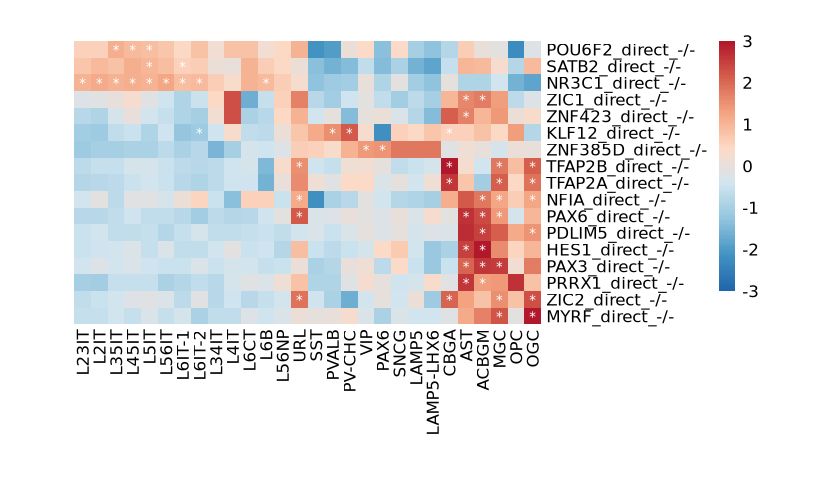

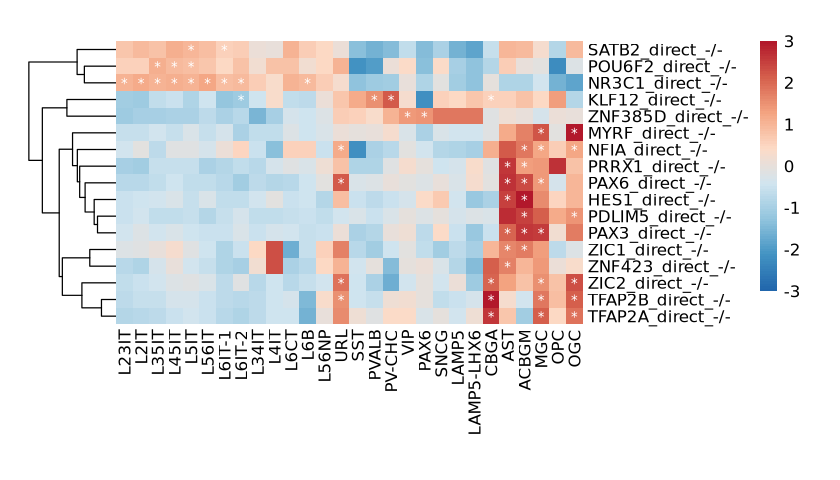

In [309]:
qgrn1 <- grep("\\-\\/\\-", rownames(rss), value = T)
qgrn2 <- grep("\\+\\/\\-", rownames(rss), value = T)
qdf <- egrn %>% filter(Gene_signature_name %in% c(qgrn1, qgrn2))
qlist <- list()
for (f in unique(qdf$eRegulon_name)){
    qrange <- qdf %>% filter(eRegulon_name == f) %>% select(Region) %>% unlist %>% unique
    score1 <- cpm[qrange, corder] %>% colMeans()
    qgene <- qdf %>% filter(eRegulon_name == f) %>% select(Gene) %>% unlist %>% unique
    score2 <- expr[qgene, corder] %>% colMeans()
    score3 <- 1 - minmax(score2)
    qlist[[f]] <- sqrt(score1*score3) %>% as.data.frame %>% setNames(f)
}

qlist <- do.call(cbind, qlist) %>% t

qlist2 <- qlist[paste0(stf, "_direct_-/-"), ]
qcol <- colnames(ncorder) #setdiff(intersect(corder, colnames(rss)), badcelltype)
max_indices <- max.col(qlist2[, qcol])
permutation_vector <- order(max_indices)
rmat <- qlist2[permutation_vector, qcol]

lmat <- do.call(rbind, fgsea_results) %>% 
reshape2::dcast(pathway ~ celltype, value.var = "padj") %>%
tibble::column_to_rownames("pathway")

lmat[is.na(lmat)] <- 1
lmat <- ifelse(lmat < 0.05, "*", "")
rownames(lmat) <- paste0(rownames(lmat), "_direct_-/-")

options(repr.plot.width = 7, repr.plot.height = 4)

t1 <- rmat %>% 
pheatmap(border_color = NA, scale = "row", cluster_rows = F, cluster_cols = F, angle_col = 90, show_rownames = T, 
         cellheight = 10, cellwidth = 10,
         display_numbers = lmat[rownames(rmat), colnames(rmat)], number_color = "white", breaks = seq(-3, 3, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(100))

t2 <- rmat %>% 
pheatmap(border_color = NA, scale = "row", cluster_rows = T, cluster_cols = F, angle_col = 90, show_rownames = T, 
         display_numbers = lmat[rownames(rmat), colnames(rmat)], number_color = "white",
         cellheight = 10, cellwidth = 10, breaks = seq(-3, 3, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(100))

## Plot STAB2 module scores

In [327]:
### SATB2_direct_-/- module scores: SATB2 expression, target ccre H3K27me3, target gene expression
mmg <- qs::qread("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529.qs")
me3 <- read_h5ad("../07.cCREs/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.h5ad")
me3 <- CreateSeuratObject(t(me3$X), meta.data = me3$obs)

mmg
me3

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”


An object of class Seurat 
38369 features across 751077 samples within 1 assay 
Active assay: RNA (38369 features, 5572 variable features)
 3 layers present: data, counts, scale.data
 9 dimensional reductions calculated: pca, harmony, umap, k27ac_umap, k27me3_umap, k27ac_spectral_harmony, k27ac_umap_new, k27me3_spectral_harmony, k27me3_umap_new

An object of class Seurat 
544735 features across 411980 samples within 1 assay 
Active assay: RNA (544735 features, 0 variable features)
 1 layer present: counts

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



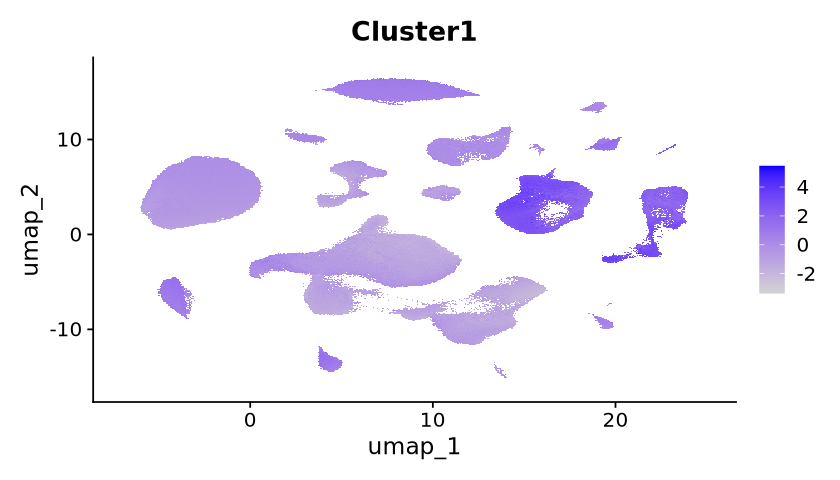

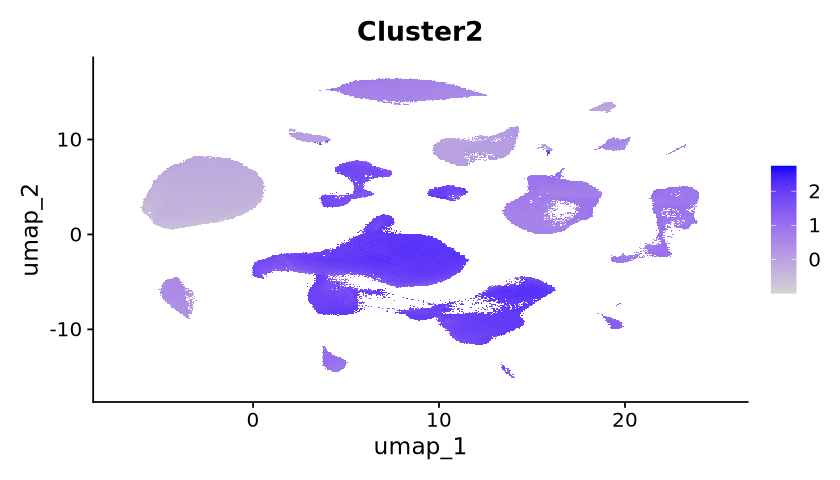

In [325]:
qgene1 <- egrn %>% filter(eRegulon_name == "SATB2_direct_-/-") %>% select(Gene) %>% unlist %>% unique 
qgene2 <- egrn %>% filter(eRegulon_name == "SATB2_direct_+/-") %>% select(Gene) %>% unlist %>% unique 
axong <- list('SATB2_direct_-/-' = qgene1, 'SATB2_direct_+/-' = qgene2)
mmg <- AddModuleScore(mmg, features = axong)
FeaturePlot(mmg, "Cluster1")
FeaturePlot(mmg, "Cluster2")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


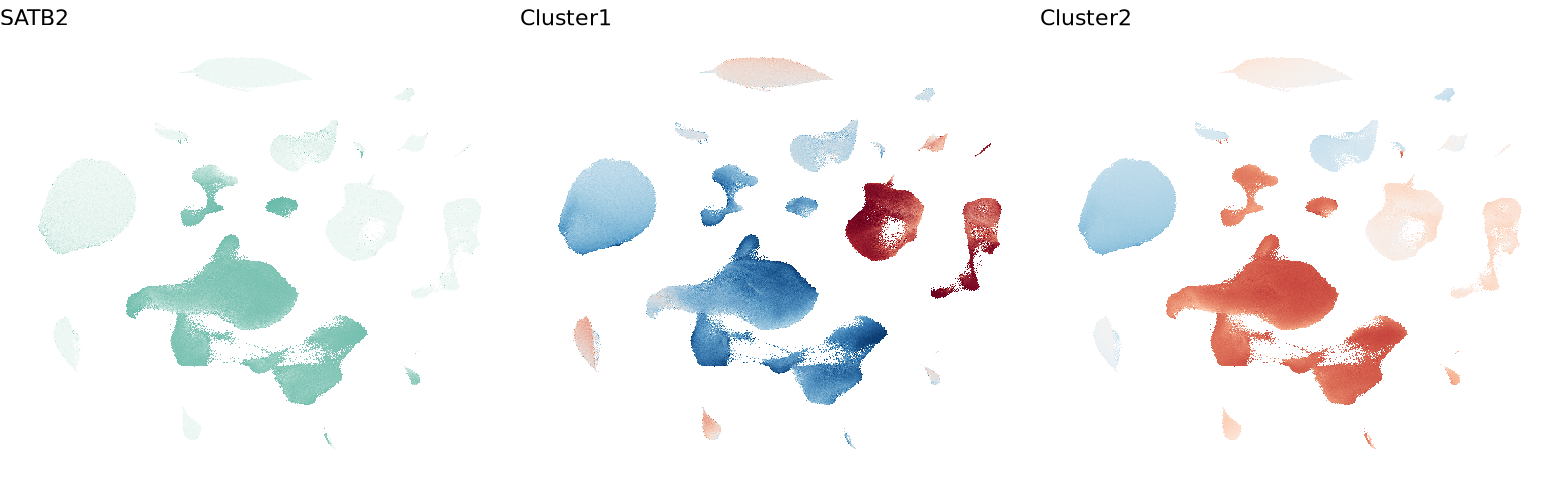

In [332]:
t1 <- FeaturePlot(mmg, "SATB2") & scale_color_gradientn(limits = c(0, 8), colours = c("#eff8f5", "#59b4a2"), oob = squish) & theme_void() & NoLegend()
t2 <- FeaturePlot(mmg, c("Cluster1", "Cluster2")) & scale_color_gradientn(limits = c(-2, 3), colours = rev(brewer.pal(n = 11, name = "RdBu")), oob = squish) & theme_void() & NoLegend()
options(repr.plot.width = 13, repr.plot.height = 4)
cowplot::plot_grid(t1, t2, ncol = 2, rel_widths = c(1, 2))